In [2]:
from matplotlib import pyplot as plt
from scipy import stats
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [3]:
game_data = pd.read_csv("../Resources/gamedata_clean.csv")
game_data.head()

,schedule_season,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium
0,2000,ATL,36,28,SF,ATL,-6.5,46.5,Georgia Dome
1,2000,BUF,16,13,TEN,BUF,-1.0,40.0,New Era Field
2,2000,CLE,7,27,JAX,JAX,-10.5,38.5,FirstEnergy Stadium
3,2000,DAL,14,41,PHI,DAL,-6.0,39.5,Texas Stadium
4,2000,GB,16,20,NYJ,GB,-2.5,44.0,Lambeau Field


In [4]:
game_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5061 entries, 0 to 5060
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   schedule_season   5061 non-null   int64  
 1   team_home         5061 non-null   object 
 2   score_home        5061 non-null   int64  
 3   score_away        5061 non-null   int64  
 4   team_away         5061 non-null   object 
 5   team_favorite_id  5061 non-null   object 
 6   spread_favorite   5061 non-null   float64
 7   over_under_line   5061 non-null   float64
 8   stadium           5061 non-null   object 
dtypes: float64(2), int64(3), object(4)
memory usage: 356.0+ KB


In [5]:
regression_df = game_data.loc[:,["schedule_season", "team_home", "score_home", "team_away", "score_away", "team_favorite_id", "spread_favorite"]]
regression_df

,schedule_season,team_home,score_home,team_away,score_away,team_favorite_id,spread_favorite
0,2000,ATL,36,SF,28,ATL,-6.5
1,2000,BUF,16,TEN,13,BUF,-1.0
2,2000,CLE,7,JAX,27,JAX,-10.5
3,2000,DAL,14,PHI,41,DAL,-6.0
4,2000,GB,16,NYJ,20,GB,-2.5
...,...,...,...,...,...,...,...
5056,2019,MIN,19,CHI,21,CHI,-4.5
5057,2019,NE,24,MIA,27,NE,-17.0
5058,2019,NYG,17,PHI,34,PHI,-3.5
5059,2019,SEA,21,SF,26,SF,-3.5


In [6]:
regression_df["home_favorite"] = regression_df.team_favorite_id == regression_df.team_home
regression_df["home_won"] = regression_df.score_home > regression_df.score_away
regression_df["home_ties"] = regression_df.score_home == regression_df.score_away
regression_df["home_loss"] = regression_df.score_home < regression_df.score_away
regression_df["score_diff"] = abs(regression_df.score_home - regression_df.score_away)
regression_df["favorite_won"] = (regression_df.home_favorite & regression_df.home_won) | (~regression_df.home_favorite & regression_df.home_loss)
regression_df["spread_covered"] = regression_df.favorite_won & (regression_df.score_diff > abs(regression_df.spread_favorite))
regression_df.head(20)

,schedule_season,team_home,score_home,team_away,score_away,team_favorite_id,spread_favorite,home_favorite,home_won,home_ties,home_loss,score_diff,favorite_won,spread_covered
0,2000,ATL,36,SF,28,ATL,-6.5,True,True,False,False,8,True,True
1,2000,BUF,16,TEN,13,BUF,-1.0,True,True,False,False,3,True,True
2,2000,CLE,7,JAX,27,JAX,-10.5,False,False,False,True,20,True,True
3,2000,DAL,14,PHI,41,DAL,-6.0,True,False,False,True,27,False,False
4,2000,GB,16,NYJ,20,GB,-2.5,True,False,False,True,4,False,False
5,2000,KC,14,IND,27,IND,-3.5,False,False,False,True,13,True,True
6,2000,MIA,23,SEA,0,MIA,-2.0,True,True,False,False,23,True,True
7,2000,MIN,30,CHI,27,MIN,-4.5,True,True,False,False,3,True,False
8,2000,NE,16,TB,21,TB,-3.0,False,False,False,True,5,True,True
9,2000,NO,10,DET,14,PICK,0.0,False,False,False,True,4,True,True


In [7]:
regression_df.spread_covered.sum()

2387

In [8]:
regression_df.loc[regression_df.spread_covered].team_favorite_id.value_counts()

NE      138
GB      117
PHI     109
IND     109
PIT     108
NO      100
BAL      98
DEN      89
SEA      88
MIN      84
KC       81
LAC      80
DAL      80
ATL      78
NYG      77
CAR      71
LAR      68
TEN      67
NYJ      63
SF       62
CHI      62
CIN      60
BUF      58
TB       58
HOU      53
MIA      51
ARI      48
JAX      48
DET      43
LVR      42
WAS      41
CLE      36
PICK     20
Name: team_favorite_id, dtype: int64

In [9]:
mask = (regression_df.team_favorite_id == "GB")
regression_df.loc[mask]

,schedule_season,team_home,score_home,team_away,score_away,team_favorite_id,spread_favorite,home_favorite,home_won,home_ties,home_loss,score_diff,favorite_won,spread_covered
4,2000,GB,16,NYJ,20,GB,-2.5,True,False,False,True,4,False,False
34,2000,GB,6,PHI,3,GB,-4.0,True,True,False,False,3,True,False
64,2000,GB,24,CHI,27,GB,-5.5,True,False,False,True,3,False,False
90,2000,GB,31,SF,28,GB,-4.5,True,True,False,False,3,True,False
192,2000,CHI,6,GB,28,GB,-2.5,False,False,False,True,22,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4946,2019,GB,24,CAR,16,GB,-5.0,True,True,False,False,8,True,True
4994,2019,NYG,13,GB,31,GB,-6.5,False,False,False,True,18,True,True
5002,2019,GB,20,WAS,15,GB,-13.0,True,True,False,False,5,True,False
5019,2019,GB,21,CHI,13,GB,-4.5,True,True,False,False,8,True,True


In [10]:
regression_df.spread_covered.value_counts()

False    2674
True     2387
Name: spread_covered, dtype: int64

In [11]:
regression_df.groupby('spread_covered').mean()

,schedule_season,score_home,score_away,spread_favorite,home_favorite,home_won,home_ties,home_loss,score_diff,favorite_won
spread_covered,,,,,,,,,,
False,2009.524308,21.346298,22.040015,-5.414921,0.665295,0.496260,0.003366,0.500374,7.363874,0.359013
True,2009.467951,25.076246,19.167574,-5.375576,0.651864,0.651864,0.000000,0.348136,16.493506,1.000000


Text(0, 0.5, '')

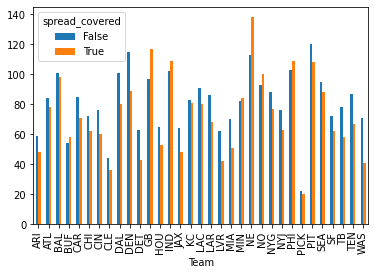

In [12]:
%matplotlib inline
pd.crosstab(regression_df.team_favorite_id,regression_df.spread_covered).plot(kind='bar')
plt.title('')
plt.xlabel('Team')
plt.ylabel('')

In [13]:
regression_df.loc[(regression_df.team_favorite_id == "DAL") & (regression_df.spread_covered == True)].schedule_season.value_counts()

2007    8
2019    7
2017    7
2008    7
2009    7
2003    7
2006    6
2016    6
2014    5
2013    3
2018    3
2011    3
2004    3
2012    2
2005    2
2000    2
2015    1
2010    1
Name: schedule_season, dtype: int64

In [14]:
regression_df.loc[(regression_df.team_favorite_id == "DAL") & (regression_df.spread_covered == True)].spread_covered.value_counts()

True    80
Name: spread_covered, dtype: int64

In [15]:
years = regression_df.schedule_season.unique()
years[0]

2000

In [19]:
covered_count = []
not_covered_count = []

for year in years:
    covered_count.append(len(regression_df.loc[(regression_df.team_favorite_id == "GB") & (regression_df.spread_covered == True) & (regression_df.schedule_season == year)]))

for year in years:
    not_covered_count.append(len(regression_df.loc[(regression_df.team_favorite_id == "GB") & (regression_df.spread_covered == False) & (regression_df.schedule_season == year)]))

In [20]:
pe_slope, pe_int, pe_r, pe_p, pe_std_err = stats.linregress(years, covered_count)
pe_fit = pe_slope * years + pe_int

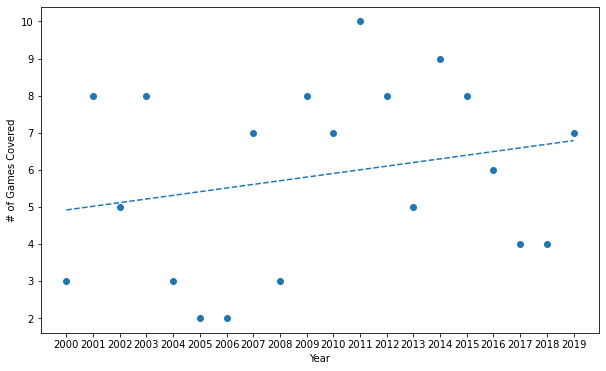

In [21]:
plt.figure(figsize=(10,6))
plt.scatter(years,covered_count)
plt.plot(years,pe_fit,"--")
plt.xticks(years)
plt.xlabel('Year')
plt.ylabel('# of Games Covered')
plt.show()

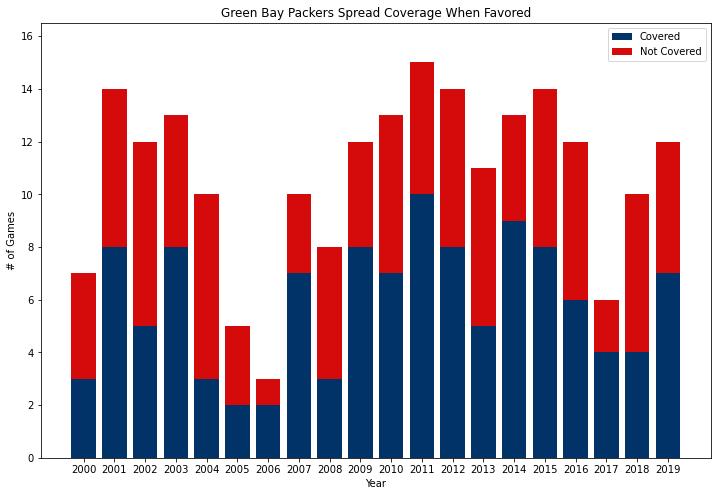

In [25]:
plt.figure(figsize=(12,8))
plt.bar(years, covered_count, label='Covered', color='#013369')
plt.bar(years, not_covered_count, bottom=covered_count, label='Not Covered', color='#D50A0A')
plt.xticks(years)
plt.title("Green Bay Packers Spread Coverage When Favored")
plt.xlabel('Year')
plt.ylabel('# of Games')
plt.ylim([0, 16.5])
plt.legend()
plt.show()

In [26]:
teams = regression_df.team_home.sort_values().unique()
teams

array(['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL',
       'DEN', 'DET', 'GB', 'HOU', 'IND', 'JAX', 'KC', 'LAC', 'LAR', 'LVR',
       'MIA', 'MIN', 'NE', 'NO', 'NYG', 'NYJ', 'PHI', 'PIT', 'SEA', 'SF',
       'TB', 'TEN', 'WAS'], dtype=object)

In [27]:
covered_count = []
not_covered_count = []

for team in teams:
    covered_count.append(len(regression_df.loc[(regression_df.team_favorite_id == team) & (regression_df.spread_covered == True)]))

for team in teams:
    not_covered_count.append(len(regression_df.loc[(regression_df.team_favorite_id == team) & (regression_df.spread_covered == False)]))
    
print(covered_count)
print(not_covered_count)

[48, 78, 98, 58, 71, 62, 60, 36, 80, 89, 43, 117, 53, 109, 48, 81, 80, 68, 42, 51, 84, 138, 100, 77, 63, 109, 108, 88, 62, 58, 67, 41]
[59, 84, 101, 54, 85, 72, 76, 44, 101, 115, 63, 97, 65, 102, 64, 83, 91, 86, 62, 70, 82, 113, 93, 88, 76, 103, 120, 95, 72, 78, 87, 71]


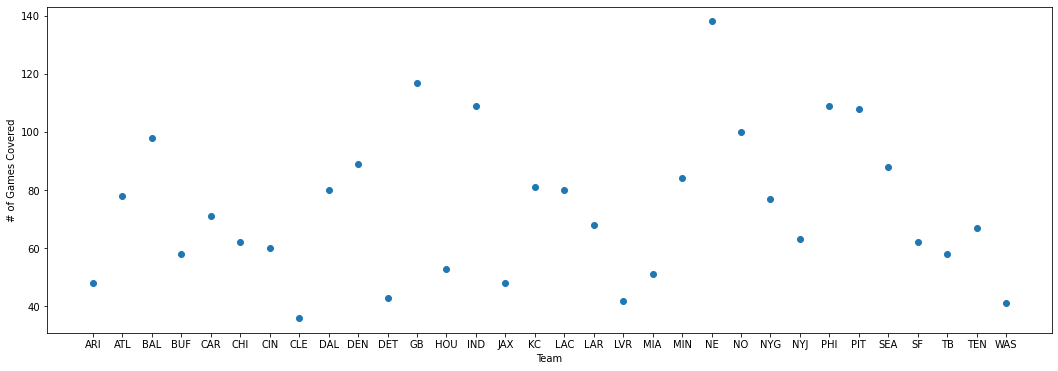

In [28]:
plt.figure(figsize=(18,6))
plt.scatter(teams,covered_count)
plt.xticks(teams)
plt.xlabel('Team')
plt.ylabel('# of Games Covered')
plt.show()

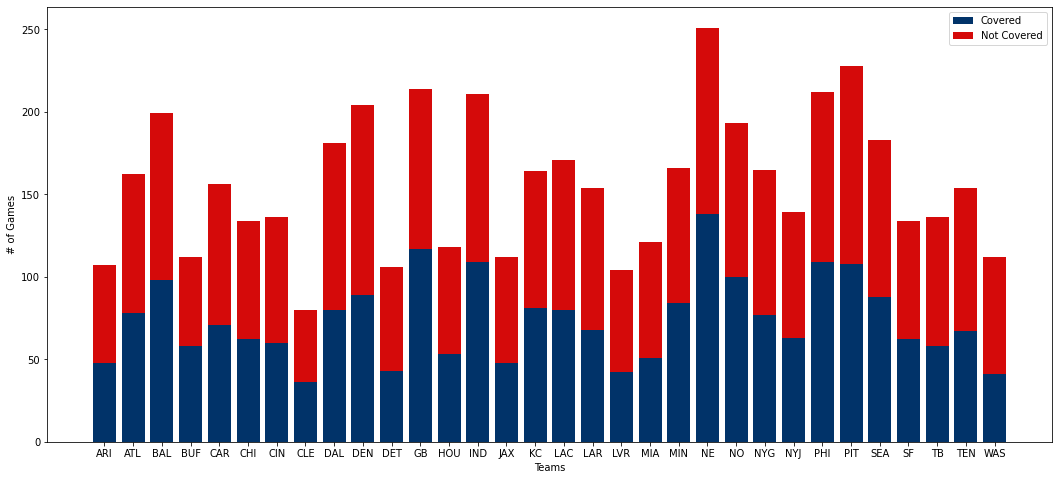

In [29]:
plt.figure(figsize=(18,8))
plt.bar(teams, covered_count, label='Covered', color='#013369')
plt.bar(teams, not_covered_count, bottom=covered_count, label='Not Covered', color='#D50A0A')
plt.xticks(teams)
plt.title("")
plt.xlabel('Teams')
plt.ylabel('# of Games')
plt.legend()
plt.show()

In [ ]:
covered = 0
not_covered = 0
push = 0

for ind in regression_df.index:
    favorite = regression_df.team_favorite_id[ind]
    spread = abs(regression_df.spread_favorite[ind])
    if (regression_df.team_home[ind] == favorite):
        score_diff = regression_df.score_home[ind] - regression_df.score_away[ind]
        if (score_diff > spread):
            print ("Spread covered. Favored team won.")
            covered += 1
        elif (score_diff == spread):
            print ("Push. Money returned.")
            push += 1
        else:
            print ("Spread not covered. Underdog team won.")
            not_covered += 1
    else:
        score_diff = regression_df.score_away[ind] - regression_df.score_home[ind]
        if (score_diff > spread):
            print ("Spread covered. Favored team won.")
            covered += 1
        elif (score_diff == spread):
            print ("Push. Money returned.")
            push += 1
        else:
            print ("Spread not covered. Underdog team won.")
            not_covered += 1
            
print(covered)
print(push)
print(not_covered)

In [30]:
regression_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5061 entries, 0 to 5060
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   schedule_season   5061 non-null   int64  
 1   team_home         5061 non-null   object 
 2   score_home        5061 non-null   int64  
 3   team_away         5061 non-null   object 
 4   score_away        5061 non-null   int64  
 5   team_favorite_id  5061 non-null   object 
 6   spread_favorite   5061 non-null   float64
 7   home_favorite     5061 non-null   bool   
 8   home_won          5061 non-null   bool   
 9   home_ties         5061 non-null   bool   
 10  home_loss         5061 non-null   bool   
 11  score_diff        5061 non-null   int64  
 12  favorite_won      5061 non-null   bool   
 13  spread_covered    5061 non-null   bool   
dtypes: bool(6), float64(1), int64(4), object(3)
memory usage: 346.1+ KB


In [67]:
feature = regression_df[['schedule_season', 'spread_favorite', 'home_favorite', 'team_favorite_id']]
feature = pd.get_dummies(feature)
target = regression_df["spread_covered"]

feature.head()

,schedule_season,spread_favorite,home_favorite,team_favorite_id_ARI,team_favorite_id_ATL,team_favorite_id_BAL,team_favorite_id_BUF,team_favorite_id_CAR,team_favorite_id_CHI,team_favorite_id_CIN,...,team_favorite_id_NYG,team_favorite_id_NYJ,team_favorite_id_PHI,team_favorite_id_PICK,team_favorite_id_PIT,team_favorite_id_SEA,team_favorite_id_SF,team_favorite_id_TB,team_favorite_id_TEN,team_favorite_id_WAS
0,2000,-6.5,True,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2000,-1.0,True,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2000,-10.5,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2000,-6.0,True,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2000,-2.5,True,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [68]:
reg = LogisticRegression()
reg.fit(np.array(feature), np.array(target))

LogisticRegression()

In [65]:
regression_df.team_favorite_id.nunique()

33

In [66]:
regression_df.team_favorite_id.value_counts()

NE      251
PIT     228
GB      214
PHI     212
IND     211
DEN     204
BAL     199
NO      193
SEA     183
DAL     181
LAC     171
MIN     166
NYG     165
KC      164
ATL     162
CAR     156
LAR     154
TEN     154
NYJ     139
CIN     136
TB      136
CHI     134
SF      134
MIA     121
HOU     118
BUF     112
WAS     112
JAX     112
ARI     107
DET     106
LVR     104
CLE      80
PICK     42
Name: team_favorite_id, dtype: int64

In [69]:
predicted = reg.predict(feature)
actual = target
probs = reg.predict_proba(feature)

C:\Users\Gage\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\Gage\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [70]:
regression_df.spread_covered.value_counts()

False    2674
True     2387
Name: spread_covered, dtype: int64

In [71]:
predicted

array([False,  True, False, ...,  True, False, False])

In [72]:
actual

0        True
1        True
2        True
3       False
4       False
        ...  
5056    False
5057    False
5058     True
5059     True
5060    False
Name: spread_covered, Length: 5061, dtype: bool

In [73]:
probs

array([[0.52972113, 0.47027887],
       [0.49450946, 0.50549054],
       [0.5707597 , 0.4292403 ],
       ...,
       [0.47735895, 0.52264105],
       [0.53218169, 0.46781831],
       [0.56039733, 0.43960267]])

In [74]:
cf_matrix = confusion_matrix(actual, predicted)
print(cf_matrix)

[[2117  557]
 [1751  636]]


In [75]:
print(classification_report(actual, predicted))

              precision    recall  f1-score   support

       False       0.55      0.79      0.65      2674
        True       0.53      0.27      0.36      2387

    accuracy                           0.54      5061
   macro avg       0.54      0.53      0.50      5061
weighted avg       0.54      0.54      0.51      5061



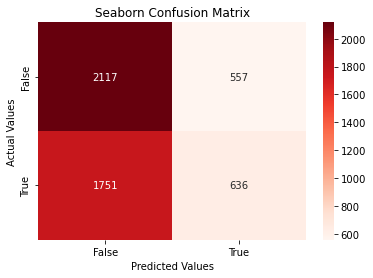

In [76]:
#Plot Confusion Matrix

ax = sns.heatmap(cf_matrix, annot=True, cmap="Reds", fmt='g')

#{"#C9002A", "#0C0948", "#EDF2E8"}
#palette=violin_colors


ax.set_title('Seaborn Confusion Matrix');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [78]:
from sklearn.ensemble import RandomForestClassifier

In [79]:
rf = RandomForestClassifier()
rf.fit(np.array(feature), np.array(target))

RandomForestClassifier()

In [80]:
predicted = rf.predict(feature)
actual = target
probs = rf.predict_proba(feature)

C:\Users\Gage\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\Gage\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [81]:
print(classification_report(actual, predicted))

              precision    recall  f1-score   support

       False       0.93      0.94      0.94      2674
        True       0.93      0.93      0.93      2387

    accuracy                           0.93      5061
   macro avg       0.93      0.93      0.93      5061
weighted avg       0.93      0.93      0.93      5061



In [82]:
probs

array([[0.2175    , 0.7825    ],
       [0.26      , 0.74      ],
       [0.55061905, 0.44938095],
       ...,
       [0.1905    , 0.8095    ],
       [0.07      , 0.93      ],
       [0.955     , 0.045     ]])

In [83]:
cf_matrix = confusion_matrix(actual, predicted)
print(cf_matrix)

[[2504  170]
 [ 177 2210]]


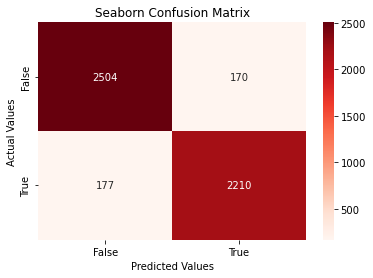

In [84]:
#Plot Confusion Matrix

ax = sns.heatmap(cf_matrix, annot=True, cmap="Reds", fmt='g')

#{"#C9002A", "#0C0948", "#EDF2E8"}
#palette=violin_colors


ax.set_title('Seaborn Confusion Matrix');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [88]:
data = feature.iloc[0]
data

schedule_season          2000
spread_favorite          -6.5
home_favorite            True
team_favorite_id_ARI        0
team_favorite_id_ATL        1
team_favorite_id_BAL        0
team_favorite_id_BUF        0
team_favorite_id_CAR        0
team_favorite_id_CHI        0
team_favorite_id_CIN        0
team_favorite_id_CLE        0
team_favorite_id_DAL        0
team_favorite_id_DEN        0
team_favorite_id_DET        0
team_favorite_id_GB         0
team_favorite_id_HOU        0
team_favorite_id_IND        0
team_favorite_id_JAX        0
team_favorite_id_KC         0
team_favorite_id_LAC        0
team_favorite_id_LAR        0
team_favorite_id_LVR        0
team_favorite_id_MIA        0
team_favorite_id_MIN        0
team_favorite_id_NE         0
team_favorite_id_NO         0
team_favorite_id_NYG        0
team_favorite_id_NYJ        0
team_favorite_id_PHI        0
team_favorite_id_PICK       0
team_favorite_id_PIT        0
team_favorite_id_SEA        0
team_favorite_id_SF         0
team_favor

In [92]:
data["schedule_season"] = 2019
data["team_favorite_id_ATL"] = 0
data["team_favorite_id_KC"] = 1
data["spread_favorite"] = -10.0

rf.predict_proba([data])

C:\Users\Gage\AppData\Local\Temp\ipykernel_25432\3666094550.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["schedule_season"] = 2019
C:\Users\Gage\AppData\Local\Temp\ipykernel_25432\3666094550.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["team_favorite_id_ATL"] = 0
C:\Users\Gage\AppData\Local\Temp\ipykernel_25432\3666094550.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["team_favorite_id_KC"] = 1
C:\User

array([[0.64233333, 0.35766667]])

In [93]:
reg.predict_proba([data])

C:\Users\Gage\anaconda3\lib\site-packages\sklearn\base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)


array([[0.55316741, 0.44683259]])